In [59]:
import numpy as np
import pandas as pd
from ipywidgets import *

import matplotlib
import matplotlib.pyplot as plt
import json

from IPython.display import display

%matplotlib inline
matplotlib.rcParams.update({'font.size': 5, 'lines.linewidth': 0.5, 'figure.dpi': 300})

In [4]:
np.random.normal(size = 100)

array([-1.30451464, -1.22221977, -1.26604188, -0.61909908, -0.6782018 ,
        0.67076062, -0.94913693,  1.88636289,  0.20189184, -0.79298402,
        0.12603476, -1.13280992, -1.42601681, -2.23155459,  0.66686705,
       -1.65455507,  2.17103929,  1.42118743, -1.92243199, -0.55455937,
        0.95988762,  1.13405132, -0.19015784, -0.21631708, -0.27579305,
        0.03318684,  0.06200646,  0.9387014 , -0.26789165, -0.38146209,
       -0.21814625, -0.35626459,  0.98624216,  0.5933256 ,  0.35792415,
       -1.05306343,  0.28946631,  0.69131681, -0.31493811, -0.28889111,
       -0.77979086,  0.38948151,  0.21256563,  0.60662293,  1.3594708 ,
        0.03240538,  0.96091832, -0.804814  ,  0.39440059, -0.50500203,
       -0.18134088,  1.7816188 ,  0.35713346,  0.02097838, -0.04117154,
        0.13151892, -0.3054959 ,  0.06408895, -0.73795848,  0.93191517,
       -0.463764  ,  0.76824883,  0.51490447,  1.6948968 ,  0.62068008,
        0.2682926 , -1.46911932,  1.11348317,  0.11153815,  1.33

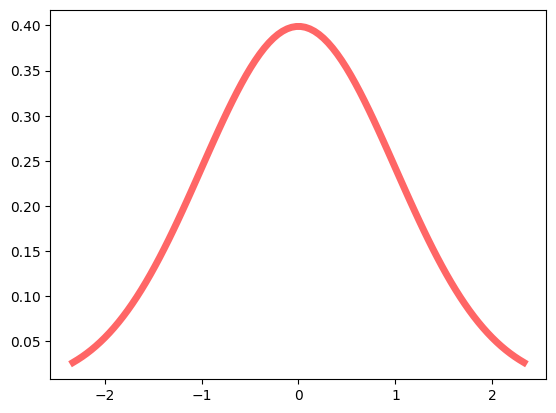

In [5]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

In [93]:
strategy = 'strategy-params/trading-curve'

strategy_params = {
    'risk': {'type': 'float', 'min': 0, 'max': 1, 'value': 0.02, 'step': 0.01},
    'winrate': {'type': 'float', 'value': 0.50, 'step': 0.02},
    'r2r': {'type': 'float', 'value': 2, 'step': 0.1},
    'n': {'type': 'int', 'value': 1000, 'step': 100},
    'cn': {'type': 'int', 'value': 10, 'step': 2},
    'fee': {'type': 'float', 'min': 0, 'max': 1, 'value': 0.002, 'step': 0.001},
    'slippage': {'type': 'float', 'min': 0, 'max': 1, 'value': 0.001, 'step': 0.001},
}
for pk, pv in strategy_params.items():
    pv['wdg'] = globals()[(pv['wdg'] if 'wdg' in pv else pv['type'].capitalize() + 'Text')](
        description=pk,disabled=False,continuous_update=False,
        value=pv['value'], step=pv['step']
    )
strategy_params = {**strategy_params}
wdgts = [pv['wdg'] for pk, pv in strategy_params.items()]

ui = widgets.VBox([widgets.HBox(wdgts[i:i+5]) for i in range(0, len(wdgts), 5)])

df = None
cn = None
def printer(risk, winrate, r2r, n, cn, fee, slippage):
    
    with open(f'{strategy}.json', "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in strategy_params.items()}))
    
    global df
    plt.close("all")
    fig = plt.figure(constrained_layout=True,figsize=(15,6))
    gs0 = fig.add_gridspec(1, 2, width_ratios=[2,1])

    gs00 = gs0[0,0].subgridspec(2, 1, height_ratios=[2,1])
    gs01 = gs0[0,1].subgridspec(2, 1, height_ratios=[1,1])

    ax001 = fig.add_subplot(gs00[0,0])
    ax002 = fig.add_subplot(gs00[1,0], sharex=ax001)
    ax003 = fig.add_subplot(gs01[0,0])
    ax004 = fig.add_subplot(gs01[1,0])
    
    xcut = norm.ppf(winrate)
    xperc = np.linspace(0,1, 100)
    ax003.plot(xperc, norm.ppf(xperc),
        'r-', lw=1, alpha=0.6, label='norm ppf')
    ax003.axvline(0.5)
    ax003.axhline()
    ax003.axhline(xcut, c='g', lw=2)
    ax003.axvline(winrate, c='g', lw=2)
    
    xnovar = np.linspace(-3, 3, 100)
    ax004.plot(xnovar, norm.cdf(xnovar),
        'r-', lw=1, alpha=0.6, label='norm cdf')
    ax004.axhline(0.5)
    ax004.axvline()
    ax004.axvline(xcut, c='g', lw=2)
    ax004.axhline(winrate, c='g', lw=2)
    
    ax001.axhline(1)
    df = pd.DataFrame()
    for i in range(cn):
        rv = np.random.normal(size = n)
        ret = np.where(rv > xcut, - risk*(1 + fee + slippage), r2r * risk*(1 - fee - slippage))
        df[f'ret_{i}'] = ret 
        df[f'cret_{i}'] = (ret + 1).cumprod()
        
        
    # df['rv'] = np.random.normal(size = n)
    # df['ret'] = np.where(df.rv > xcut, - risk, r2r * risk)
    # df.plot(ax=ax001)
    ret_cols = [f'ret_{i}' for i in range(cn)]
    cret_cols = [f'cret_{i}' for i in range(cn)]
    df[cret_cols].plot(ax=ax001)
    
    ax002.axhline(1)
    df[ret_cols].agg(np.sum, axis=1).add(1).cumprod().plot(ax=ax002, lw=1, c='b')
    # df['cap'] = df.ret.add(1).cumprod()
    # ax001.plot(df.cap)
    
    # df.avg().plot(ax=ax002)
    
with open(f'{strategy}.json') as f: 
    js = json.loads(f.read());
    for k, v in strategy_params.items(): 
        if k in js: v['wdg'].value=js[k];
        
out = widgets.interactive_output(printer, {k : v['wdg'] for k,v in strategy_params.items()})
display(ui, out)  

Output()

In [84]:
df[[f'ret_{i}' for i in range(strategy_params['cn']['value'])]].agg(np.sum, axis=1).add(1).cumprod()

0         0.975000
1         1.018875
2         0.957742
3         0.900278
4         0.877771
          ...     
995    9359.263542
996    9452.856178
997    9216.534773
998    9953.857555
999    9705.011116
Length: 1000, dtype: float64